In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Project4/')
!pwd

/content/drive/MyDrive/Project4


In [ ]:
import os
import re
import nltk
import string
import numpy as np
import pandas as pd

nltk.download('stopwords')
from nltk.corpus import stopwords

import keras.utils as ku
from keras.preprocessing.text import Tokenizer

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense,SpatialDropout1D, GRU
from tensorflow.keras.callbacks import ModelCheckpoint , EarlyStopping

import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Read and exploring the data

In [ ]:
data = pd.read_csv('process_data/new_dataset.csv', low_memory=False)

In [ ]:
df = data.copy()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101645 entries, 0 to 101644
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   poem_id     101645 non-null  int64 
 1   poet_name   101645 non-null  object
 2   poem_title  101645 non-null  object
 3   poem_text   101645 non-null  object
 4   era         101645 non-null  object
 5   country     38215 non-null   object
 6   poem_style  58020 non-null   object
dtypes: int64(1), object(6)
memory usage: 5.4+ MB


In [ ]:
df.head()

,poem_id,poet_name,poem_title,poem_text,era,country,poem_style
0,21,بدر شاكر السياب,أنشودة المطر,عيناك غابتا نخيل ساعة السحر او شرفتان راح يناي...,العصر الحديث,العراق,فصحى
1,65546,بدر شاكر السياب,أقداح و أحلام,انا لا ازال و في يدي قدحي ياليل اين تفرق الشر...,العصر الحديث,العراق,فصحى
2,65561,بدر شاكر السياب,هوى واحد !,علي مقلتيك ارتشفت النجوم وعانقت امالي الايبة ...,العصر الحديث,العراق,فصحى
3,65554,بدر شاكر السياب,أساطير,اساطير من حشرجات الزمان نسيج اليد البالية رواه...,العصر الحديث,العراق,فصحى
4,65550,بدر شاكر السياب,اللقاء الأخير,والتف حولك ساعداي ومال جيدك في اشتهاء كالزهرة ...,العصر الحديث,العراق,فصحى


In [ ]:
df.describe()

,poem_id
count,101645.000000
mean,37906.507964
std,25760.366513
min,0.000000
25%,15087.000000
50%,32084.000000
75%,60297.000000
max,86650.000000


In [ ]:
df.shape

(101645, 7)

# 3.	Remove any unwanted characters (e.g., “-“, “;”).

### Removing Non-arabic letters, numbers, amiss typo and special characters


In [ ]:
#print (string.punctuation)

arabic_punctuations = '''«»`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations
print (punctuations_list)


arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)

print (arabic_diacritics)

«»`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
re.compile('\n                             ّ    | # Tashdid\n                             َ    | # Fatha\n                             ً    | # Tanwin Fath\n                             ُ    | # Damma\n         , re.VERBOSE)


In [ ]:
# function to clean and normalize text
def clean_text(text):
    search = ["أ","إ","آ","ة","_","-","/",".","،"," و "," يا ",'"',"ـ","'","ى","\\",'\n', '\t','&quot;','?','؟','!']
    replace = ["ا","ا","ا","ه"," "," ","","",""," و"," يا","","","","ي","",' ', ' ',' ',' ? ',' ؟ ',' ! ']

    p_tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    text = re.sub(p_tashkeel,"", text)
    p_longation = re.compile(r'(.)\1+')
    subst = r"\1\1"
    text = re.sub(p_longation, subst, text)

    text = text.replace('وو', 'و')
    text = text.replace('يي', 'ي')
    text = text.replace('اا', 'ا')

    for i in range(0, len(search)):
       #print (search[i], replace[i])
        text = text.replace(search[i], replace[i])
    text = text.strip()
    return text

def remove_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    return text

def remove_diacritics(text):
    text = re.sub(arabic_diacritics, '', text)
    return text

def remove_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)



# clean and normalize text
df["poem_text_clean"]  = df.poem_text.apply(lambda x: clean_text(x))

# remove punctuation
df.poem_text_clean  = df.poem_text_clean.apply(lambda x: remove_punctuations(x))

# remove diacritics
df.poem_text_clean  = df.poem_text_clean.apply(lambda x: remove_diacritics(x))

# remove repeating char
df.poem_text_clean  = df.poem_text_clean.apply(lambda x: remove_repeating_char(x))

# remove english letters
df.poem_text_clean = df.poem_text_clean.apply(lambda x: re.sub(r'[a-zA-Z]', '', x))

# remove a special character
df.poem_text_clean = df.poem_text_clean.apply(lambda x: re.sub(r'[_]+', '', x))

# remove english numbers
df.poem_text_clean = df.poem_text_clean.apply(lambda x: re.sub(r'/[0-9\u0621-\u064A]+/u', '', x))

# remove space
df.poem_text_clean  = df.poem_text_clean.str.replace(r'\d+','', regex=True)

In [ ]:
df.head()

,poem_id,poet_name,poem_title,poem_text,era,country,poem_style,poem_text_clean
0,21,بدر شاكر السياب,أنشودة المطر,عيناك غابتا نخيل ساعة السحر او شرفتان راح يناي...,العصر الحديث,العراق,فصحى,عيناك غابتا نخيل ساعه السحر او شرفتان راح يناي...
1,65546,بدر شاكر السياب,أقداح و أحلام,انا لا ازال و في يدي قدحي ياليل اين تفرق الشر...,العصر الحديث,العراق,فصحى,انا لا ازال وفي يدي قدحي ياليل اين تفرق الشرب ...
2,65561,بدر شاكر السياب,هوى واحد !,علي مقلتيك ارتشفت النجوم وعانقت امالي الايبة ...,العصر الحديث,العراق,فصحى,علي مقلتيك ارتشفت النجوم وعانقت امالي الايبه و...
3,65554,بدر شاكر السياب,أساطير,اساطير من حشرجات الزمان نسيج اليد البالية رواه...,العصر الحديث,العراق,فصحى,اساطير من حشرجات الزمان نسيج اليد الباليه رواه...
4,65550,بدر شاكر السياب,اللقاء الأخير,والتف حولك ساعداي ومال جيدك في اشتهاء كالزهرة ...,العصر الحديث,العراق,فصحى,والتف حولك ساعداي ومال جيدك في اشتهاء كالزهره ...


In [ ]:
#for test remove tashkeel
tt = ''
lenght = 1000
x = 0
for i, row in enumerate(df.poem_title[:lenght]):
    ##tt += row + "\n"
    l1 = len(row)
    text  = re.sub(arabic_diacritics, '', row)
    if  l1 > len(text):
        print (row , "\t|" ,text)
        print ("-"*50)

# verses = verses.splitlines()
# len(verses)

يا نهـر  	| يا نهر 
--------------------------------------------------
منشورَاتٌ فِدَائيّة على جُدْرَانِ إسْرائيل  	| منشورات فدائية على جدران إسرائيل 
--------------------------------------------------
رفقاً باعصابي  	| رفقا باعصابي 
--------------------------------------------------
تقرير سري جداً من بلاد قمعستان  	| تقرير سري جدا من بلاد قمعستان 
--------------------------------------------------
سُلالات  	| سلالات 
--------------------------------------------------
اِختاري  	| اختاري 
--------------------------------------------------
أحبك جداً  	| أحبك جدا 
--------------------------------------------------
هاملت شاعراً  	| هاملت شاعرا 
--------------------------------------------------
الدخول إلى هيروشيمَا  	| الدخول إلى هيروشيما 
--------------------------------------------------
الشَعْرُ الأسود  	| الشعر الأسود 
--------------------------------------------------
البَرْق  	| البرق 
--------------------------------------------------
طموحُ الوردة  	| طموح الوردة 
-----------------

 ### Loading and Cleaning Reviews

In dataset preparation step, we will first perform text cleaning of the data which includes removal of punctuations and lower casing all the words.

In [ ]:
stopword = set(stopwords.words('arabic'))
print( len (stopword))
print (stopword)

701
{'ثلاثون', 'أحد', 'زعم', 'ألفى', 'لي', 'هيهات', 'سرا', 'لو', 'الذي', 'انقلب', 'ست', 'إياهن', 'إليكم', 'جنيه', 'إياهما', 'هناك', 'أوّهْ', 'كم', 'عيانا', 'غداة', 'أخذ', 'ظلّ', 'هَاتِه', 'تفعلين', 'نفس', 'اللتين', 'فإن', 'دينار', 'مساء', 'سين', 'أمسى', 'إذ', 'مائة', 'طاء', 'إليكما', 'ح', 'خمسمائة', 'جير', 'تعسا', 'ليس', 'أمّا', 'بس', 'بؤسا', 'أمام', 'عشرون', 'كِخ', 'كانون', 'تخذ', 'مكانكم', 'حتى', 'لكن', 'كاف', 'تموز', 'ذاك', 'أولاء', 'أفريل', 'جويلية', 'خ', 'إيهٍ', 'تِه', 'سبعمائة', 'سحقا', 'هَذا', 'ذانك', 'أبريل', 'كن', 'أنشأ', 'كيفما', 'كاد', 'التي', 'ذينك', 'لكنَّ', 'اربعين', 'الآن', 'خمسمئة', 'اللواتي', 'كلاهما', 'كلتا', 'لما', 'وإذ', 'شمال', 'لست', 'ز', 'سرعان', 'راح', 'بهما', 'يفعلون', 'آمينَ', 'لدى', 'كليهما', 'أفعل به', 'منه', 'عن', 'سبعمئة', 'رابع', 'بخ', 'إليكن', 'غير', 'تَيْنِ', 'حيَّ', 'ثمانمئة', 'آض', 'لام', 'ديسمبر', 'تحوّل', 'أنتم', 'زاي', 'معاذ', 'كلما', 'حرى', 'ثاء', 'خاء', 'أبو', 'ذا', 'لستما', 'بَلْهَ', 'إياكما', 'هَذِه', 'أعلم', 'بمن', 'بهم', 'ضاد', 'فلان', 'تفعلا

In [ ]:
# turn a doc into clean tokens
def clean_doc(doc):

    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    tokens = [w for w in tokens if not w in stopword]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]

    #return tokens
    return  " ".join(tokens) +"\n"

In [ ]:
text = df.poem_text[:1]
text , type(text)

(0    عيناك غابتا نخيل ساعة السحر او شرفتان راح يناي...
 Name: poem_text, dtype: object,
 pandas.core.series.Series)

In [ ]:
text = text.values[0]
text

'عيناك غابتا نخيل ساعة السحر او شرفتان راح يناي عنهما القمر عيناك حين تبسمان تورق الكروم وترقص الاضواء كالاقمار في نهر يرجه المجذاف وهنا ساعة السحر كانما تنبض في غوريهما النجوم وتغرقان في ضباب من اسي شفيف كالبحر سرح اليدين فوقه المساء دفء الشتاء فيه وارتعاشة الخريف والموت والميلاد والظلام والضياء فتستفيق ملء روحي رعشة البكاء ونشوة وحشية تعانق السماء كنشوة الطفل اذا خاف من القمر كان اقواس السحاب تشرب الغيوم وقطرة فقطرة تذوب في المطر وكركر الاطفال في عراءش الكروم ودغدغت صمت العصافير علي الشجر انشودة المطر مطر مطر مطر تثاءب المساء والغيوم ما تزال تسح ما تسح من دموعها الثقال كان طفلا بات يهذي قبل ان ينام بان امه – التي افاق منذ عام فلم يجدها ثم حين لج في السءال قالوا له "بعد غد تعود " لا بد ان تعود وان تهامس الرفاق انها هناك في جانب التل تنام نومة الحود تسف من ترابها وتشرب المطر كان صيادا حزينا يجمع الشباك ويلعن المياه والقدر وينثر الغناء حيث يافل القمر مطر مطر اتعلمين اي حزن يبعث المطر وكيف تنشج المزاريب اذا انهمر وكيف يشعر الوحيد فيه بالضياع بلا انتهاء – كالدم المراق كالجياع كالحب كالاطف

In [ ]:
print ("len text befor clean " , len(text.split()))
text_clean = clean_doc(text)
print(text_clean)

print ("len token after clean " , len(text_clean.split()))

len text befor clean  509
عيناك غابتا نخيل ساعة السحر او شرفتان يناي عنهما القمر عيناك تبسمان تورق الكروم وترقص الاضواء كالاقمار نهر يرجه المجذاف وهنا ساعة السحر كانما تنبض غوريهما النجوم وتغرقان ضباب اسي شفيف كالبحر سرح اليدين فوقه المساء دفء الشتاء وارتعاشة الخريف والموت والميلاد والظلام والضياء فتستفيق ملء روحي رعشة البكاء ونشوة وحشية تعانق السماء كنشوة الطفل اذا خاف القمر اقواس السحاب تشرب الغيوم وقطرة فقطرة تذوب المطر وكركر الاطفال عراءش الكروم ودغدغت صمت العصافير علي الشجر انشودة المطر مطر مطر مطر تثاءب المساء والغيوم تزال تسح تسح دموعها الثقال طفلا يهذي ان ينام بان امه افاق عام فلم يجدها لج السءال قالوا غد تعود بد ان تعود وان تهامس الرفاق انها جانب التل تنام نومة الحود تسف ترابها وتشرب المطر صيادا حزينا يجمع الشباك ويلعن المياه والقدر وينثر الغناء يافل القمر مطر مطر اتعلمين اي حزن يبعث المطر وكيف تنشج المزاريب اذا انهمر وكيف يشعر الوحيد بالضياع بلا انتهاء كالدم المراق كالجياع كالحب كالاطفال كالموتي المطر ومقلتاك تطيفان المطر وعبر امواج الخليج تمسح البروق سواحل العراق بالنجوم وال

# 3.2 Generating Sequence of N-gram Tokens

Language modelling requires a sequence input data, as given a sequence (of words/tokens) the aim is the predict next word/token.  

The next step is Tokenization. Tokenization is a process of extracting tokens (terms / words) from a corpus. Python’s library Keras has inbuilt model for tokenization which can be used to obtain the tokens and their index in the corpus. After this step, every text document in the dataset is converted into sequence of tokens.


In [ ]:
 # clean and normalize text
df["poem_text_clean"]  = df.poem_text.apply(lambda x: clean_doc(x))

In [ ]:
df.head()

,poem_id,poet_name,poem_title,poem_text,era,country,poem_style,poem_text_clean
0,21,بدر شاكر السياب,أنشودة المطر,عيناك غابتا نخيل ساعة السحر او شرفتان راح يناي...,العصر الحديث,العراق,فصحى,عيناك غابتا نخيل ساعة السحر او شرفتان يناي عنه...
1,65546,بدر شاكر السياب,أقداح و أحلام,انا لا ازال و في يدي قدحي ياليل اين تفرق الشر...,العصر الحديث,العراق,فصحى,انا ازال يدي قدحي ياليل اين تفرق الشرب زلت اشر...
2,65561,بدر شاكر السياب,هوى واحد !,علي مقلتيك ارتشفت النجوم وعانقت امالي الايبة ...,العصر الحديث,العراق,فصحى,علي مقلتيك ارتشفت النجوم وعانقت امالي الايبة و...
3,65554,بدر شاكر السياب,أساطير,اساطير من حشرجات الزمان نسيج اليد البالية رواه...,العصر الحديث,العراق,فصحى,اساطير حشرجات الزمان نسيج اليد البالية رواها ظ...
4,65550,بدر شاكر السياب,اللقاء الأخير,والتف حولك ساعداي ومال جيدك في اشتهاء كالزهرة ...,العصر الحديث,العراق,فصحى,والتف حولك ساعداي ومال جيدك اشتهاء كالزهرة الو...


In [ ]:
verse = ''
lenght = 20
for i, row in enumerate(df.poem_text_clean[:lenght]):
    verse += row + "\n"
print (len(verse))
verse = verse.splitlines()
len(verse)

28390


40

In [ ]:
verse[:1]

['عيناك غابتا نخيل ساعة السحر او شرفتان يناي عنهما القمر عيناك تبسمان تورق الكروم وترقص الاضواء كالاقمار نهر يرجه المجذاف وهنا ساعة السحر كانما تنبض غوريهما النجوم وتغرقان ضباب اسي شفيف كالبحر سرح اليدين فوقه المساء دفء الشتاء وارتعاشة الخريف والموت والميلاد والظلام والضياء فتستفيق ملء روحي رعشة البكاء ونشوة وحشية تعانق السماء كنشوة الطفل اذا خاف القمر اقواس السحاب تشرب الغيوم وقطرة فقطرة تذوب المطر وكركر الاطفال عراءش الكروم ودغدغت صمت العصافير علي الشجر انشودة المطر مطر مطر مطر تثاءب المساء والغيوم تزال تسح تسح دموعها الثقال طفلا يهذي ان ينام بان امه افاق عام فلم يجدها لج السءال قالوا غد تعود بد ان تعود وان تهامس الرفاق انها جانب التل تنام نومة الحود تسف ترابها وتشرب المطر صيادا حزينا يجمع الشباك ويلعن المياه والقدر وينثر الغناء يافل القمر مطر مطر اتعلمين اي حزن يبعث المطر وكيف تنشج المزاريب اذا انهمر وكيف يشعر الوحيد بالضياع بلا انتهاء كالدم المراق كالجياع كالحب كالاطفال كالموتي المطر ومقلتاك تطيفان المطر وعبر امواج الخليج تمسح البروق سواحل العراق بالنجوم والمحار كانها تهم بالشروق ف

In [ ]:
tokenizer = Tokenizer()

def get_sequence_of_tokens(verse):
    ## tokenization
    tokenizer.fit_on_texts(verse)
    total_words = len(tokenizer.word_index) + 1

    ## convert data to sequence of tokens
    input_sequences = []
    for line in verse:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    return input_sequences, total_words

In [ ]:
inp_sequences, total_words = get_sequence_of_tokens(verse)
inp_sequences[:10] , total_words

([[57, 763],
  [57, 763, 764],
  [57, 763, 764, 185],
  [57, 763, 764, 185, 121],
  [57, 763, 764, 185, 121, 13],
  [57, 763, 764, 185, 121, 13, 765],
  [57, 763, 764, 185, 121, 13, 765, 322],
  [57, 763, 764, 185, 121, 13, 765, 322, 766],
  [57, 763, 764, 185, 121, 13, 765, 322, 766, 58],
  [57, 763, 764, 185, 121, 13, 765, 322, 766, 58, 57]],
 3006)

In [ ]:
#tokenizer.word_index

In [ ]:
print (len([len(x) for x in inp_sequences]))
max([len(x) for x in inp_sequences])

4889


767

In [ ]:
def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    #max_sequence_len = 256

    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    label = ku.to_categorical(label, num_classes=total_words)
    return predictors, label, max_sequence_len

In [ ]:
predictors, label, max_sequence_len = generate_padded_sequences(inp_sequences)

In [ ]:
predictors.shape , label.shape

((4889, 766), (4889, 3006))

In [ ]:
label, max_sequence_len

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 767)

In [ ]:

#Define the GRU model architecture:
def create_model_GRU(max_sequence_len, total_words ,embedding_dim=10):
    input_len = max_sequence_len - 1

    model = Sequential()
    model.add(Embedding(total_words, embedding_dim,  input_length = input_len))
    model.add(SpatialDropout1D(0.2))
    model.add(GRU(128, return_sequences = False))
    model.add(Dropout(0.2))
    model.add(Dense(total_words, activation='softmax'))

    #Compile the model:
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    return model



model = create_model_GRU(max_sequence_len, total_words)
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 766, 10)           30060     
                                                                 
 spatial_dropout1d (Spatial  (None, 766, 10)           0         
 Dropout1D)                                                      
                                                                 
 gru (GRU)                   (None, 128)               53760     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3006)              387774    
                                                                 
Total params: 471594 (1.80 MB)
Trainable params: 471594 (1.80 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

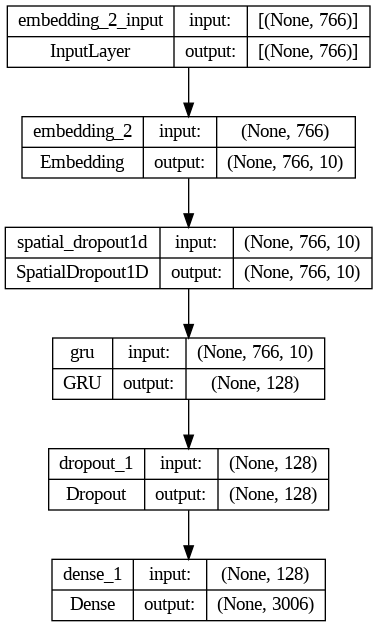

In [ ]:
# representation of model layers
# from keras.utils.vis_utils import plot_model

# representation of model layers
tf.keras.utils.plot_model(model, to_file='images/Gru_node.png', show_shapes=True,)

In [ ]:
checkpoint_path = "model_gen/training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
callback =[
    ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
]

# # Train the model with the new callback
# history = model.fit(predictors, label, epochs=5,
#                     #batch_size = 16,
#                     validation_split= 0.2,
#                     callbacks=[callback])  # Pass callback to training

In [ ]:
epochs = 5
# fit model using our gpu
with tf.device('/gpu:0'):
    # Train the model with the new callback
    history = model.fit(predictors, label, epochs=epochs,
                        #batch_size = 16,
                        validation_split= 0.2,
                        callbacks=[callback])  # Pass callback to training

Epoch 1/5
123/123 [==============================] - ETA: 0s - loss: 8.0031 - accuracy: 0.0199
Epoch 1: saving model to model_gen/training_1/cp.ckpt
123/123 [==============================] - 39s 231ms/step - loss: 8.0031 - accuracy: 0.0199 - val_loss: 8.0215 - val_accuracy: 0.0215
Epoch 2/5
  4/123 [..............................] - ETA: 24s - loss: 7.9687 - accuracy: 0.0156

KeyboardInterrupt: ignored

In [ ]:
#Plot
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


# model_2

In [ ]:
def create_model_2(max_sequence_len, total_words):
    input_len = max_sequence_len - 1

    model = Sequential()
    # Add Input Embedding Layer
    model.add(Embedding(total_words, 50, input_length=input_len))
    # Add Hidden Layer 1 - LSTM Layer
    model.add(LSTM(100, return_sequences=True))
    #model.add(Dropout(0.1))
    # Add Hidden Layer 2 - LSTM Layer
    model.add(LSTM(100))
    #model.add(Dropout(0.1))
    model.add(Dense(100, activation='relu'))
    # Add Output Layer
    model.add(Dense(total_words, activation='softmax'))

    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model2 = create_model_2(max_sequence_len, total_words)
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 766, 50)           150300    
                                                                 
 lstm (LSTM)                 (None, 766, 100)          60400     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 100)               10100     
                                                                 
 dense_1 (Dense)             (None, 3006)              303606    
                                                                 
Total params: 604806 (2.31 MB)
Trainable params: 604806 (2.31 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
checkpoint_path = "model_gen/training_2/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5),
           ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)]

# Train the model with the new callback
history2 = model2.fit(predictors, label, epochs=5,
                        #batch_size = 16,
                        validation_split= 0.2,
                        callbacks=callbacks)  # Pass callback to training

Epoch 1/5
123/123 [==============================] - ETA: 0s - loss: 8.0000 - accuracy: 0.0205
Epoch 1: saving model to model_gen/training_2/cp.ckpt
123/123 [==============================] - 59s 398ms/step - loss: 8.0000 - accuracy: 0.0205 - val_loss: 8.0147 - val_accuracy: 0.0215
Epoch 2/5
123/123 [==============================] - ETA: 0s - loss: 7.7796 - accuracy: 0.0212
Epoch 2: saving model to model_gen/training_2/cp.ckpt
123/123 [==============================] - 29s 240ms/step - loss: 7.7796 - accuracy: 0.0212 - val_loss: 8.1592 - val_accuracy: 0.0215
Epoch 3/5
123/123 [==============================] - ETA: 0s - loss: 7.6453 - accuracy: 0.0212
Epoch 3: saving model to model_gen/training_2/cp.ckpt
123/123 [==============================] - 29s 237ms/step - loss: 7.6453 - accuracy: 0.0212 - val_loss: 8.6437 - val_accuracy: 0.0215
Epoch 4/5
123/123 [==============================] - ETA: 0s - loss: 7.5899 - accuracy: 0.0212
Epoch 4: saving model to model_gen/training_2/cp.ckpt
12

ValueError: ignored

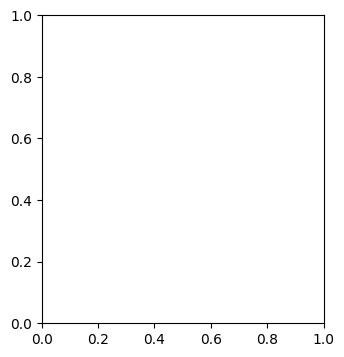

In [ ]:
#Plot
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(5)
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
## Save Model

# from pickle import dump
# # save the model to file
# model.save('model.hdh5')
# # save the tokenizer
# dump(tokenizer, open('tokenizer.pkl', 'wb'))

# 5. Generating the text

Great, our model architecture is now ready and we can train it using our data. Next lets write the function to predict the next word based on the input words (or seed text). We will first tokenize the seed text, pad the sequences and pass into the trained model to get predicted word. The multiple predicted words can be appended together to get predicted sequence.


In [ ]:
def generate_text(seed_text, next_words, model, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predict_x = model.predict(token_list, verbose=0)
        classes_x=np.argmax(predict_x,axis=1)

        output_word = ""
        for word,index in tokenizer.word_index.items():
            #if index == predict_x:
            if index == classes_x:
                output_word = word
                break
        seed_text += " "+output_word
    return seed_text.title()

## 6. Some Results

In [ ]:
text1 = "علي فم الوليد"

In [ ]:
print (generate_text(text1, 15,model, max_sequence_len))

علي فم الوليد علي علي علي علي علي وقلبي وقلبي وقلبي وقلبي وقلبي وقلبي وقلبي وقلبي وقلبي وقلبي


In [ ]:
text2 = "المطر حمراء"
print (generate_text(text2, 14, model, max_sequence_len))

المطر حمراء علي علي علي علي علي هداياك وقلبي وقلبي وقلبي وقلبي وقلبي وقلبي وقلبي وقلبي


In [ ]:
text3 = "مبسم جديد"
print (generate_text(text3, 14, model, max_sequence_len))

مبسم جديد علي علي علي علي علي علي صدري وقلبي وقلبي وقلبي وقلبي وقلبي وقلبي وقلبي


# test model2

In [ ]:
# model2
text1 = "علي فم الوليد"
print (generate_text(text1, 15,model2, max_sequence_len))

In [ ]:
text2 = "المطر حمراء"
print (generate_text(text2, 14, model2, max_sequence_len))

In [ ]:
text3 = "مبسم جديد"
print (generate_text(text3, 14, model2, max_sequence_len))